# Jet Data Reupload

In this code, we use the method from [Pérez-Salinas et al. (2019)](https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html) and applying it on Jet-data.

## Google Colab

- Google may ask for your authorization to access in your Google drive.
- Simply remove this cell if you want to run on local. (Or comment this cell)
- If there is any error showing up ssaying that couldn't find quantum devices, just restart your kernel. (Since Pennylane has stated that Colab have some problem installing pennylane, the only way is to restart your Colab kernel.)

In [1]:
!pip install pennylane
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


## Import modules

In [2]:
# pennylane - for quantum machine learning
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer, NesterovMomentumOptimizer, MomentumOptimizer

# plotting module
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# setting seed for rresult eproduction
np.random.seed(100)
qml.about()

Name: PennyLane
Version: 0.14.1
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: None
Author-email: None
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: semantic-version, numpy, autograd, scipy, toml, appdirs, networkx
Required-by: 
Platform info:           Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
Python version:          3.7.10
Numpy version:           1.19.5
Scipy version:           1.4.1
Installed devices:
- default.gaussian (PennyLane-0.14.1)
- default.mixed (PennyLane-0.14.1)
- default.qubit (PennyLane-0.14.1)
- default.qubit.autograd (PennyLane-0.14.1)
- default.qubit.jax (PennyLane-0.14.1)
- default.qubit.tf (PennyLane-0.14.1)
- default.tensor (PennyLane-0.14.1)
- default.tensor.tf (PennyLane-0.14.1)


## Generating trial data and loading Jet data

- trial data: randomly generate data that uniformly distributed in a hypercube. Then label 0, 1 inside and outside the hypersphere respectively.

- jet data: can be modified by yourself for other data. **Remember to change the path**. The data can be downloaded [here](https://drive.google.com/drive/folders/1CY__G0AFOuYC_NBX_oTTetXd9BcliesI?usp=sharing)

In [3]:
def trial_data(train_num, test_num, dimension=4, radius=1, length=2):
    '''
    Generate random-uniform data in hypercube
    - label 0: inside the hypersphere
    - label 1: outside the hypersphere but inside the hypercube

    Args:
        train_num: number of training data
        test_num : number of testing data
        dimension: the number of features per data
        radius   : the radius of the hypersphere
        length   : the length of the hypercube
    '''
    # randomly preparing X-data
    X = (np.random.rand(train_num+test_num, dimension)-0.5)*length
    Y = []
    for i in range(train_num+test_num):
        if np.linalg.norm(X[i]) <= radius: Y.append(0) # inside  the hypersphere
        else: Y.append(1)                              # outside the hypersphere
    # since input data is not going to be trained, we set: requires_grad = False
    X = np.array(X, requires_grad=False)
    Y = np.array(Y, requires_grad=False)
    return X[:train_num], Y[:train_num], X[train_num:], Y[train_num:]

In [4]:
def jet_data(train_num, test_num, path='/content/drive/MyDrive/QML_project/jet_data'):
    '''
    Loading the Jet data
    - only load train and test data by default
    - modify the path of your data

    Args:
        train_num: number of training data
        test_num : number of testing data
        path     : path of your data path
    '''

    print(f'Start loading Jet data ...')
    x_train = np.load(path+"/VQC_TJET_4VAR_NO_TENSOR_X_train.npy")
    y_train = np.load(path+"/VQC_TJET_4VAR_NO_TENSOR_Y_train.npy")
    x_test  = np.load(path+"/VQC_TJET_4VAR_NO_TENSOR_X_test.npy")
    y_test  = np.load(path+"/VQC_TJET_4VAR_NO_TENSOR_Y_test.npy")

    # randomly select part of data
    total_train, total_test = x_train.shape[0], x_test.shape[0]
    random_pick_train = np.random.permutation(range(total_train))[:train_num]
    random_pick_test  = np.random.permutation(range(total_test))[:test_num]
    x_train = x_train[random_pick_train]
    y_train = y_train[random_pick_train]
    x_test  = x_test[random_pick_test]
    y_test  = y_test[random_pick_test]

    print(f"x_train shape : {x_train.shape} | y_train shape : {y_train.shape}")
    print(f"x_test shape : {x_test.shape} | y_test shape : {y_test.shape}")
    return x_train, y_train, x_test, y_test

## Functions

### Density Matrix

- For two classes, we define label 0 to be $|0>$ state, and label 1 to be $|1>$ state.
- We can define the i-th label density matrix to be $|i><i|$

In [5]:
def density_matrix(label):
    if label == 0:
        # |0><0|
        return np.array([[1,0],[0,0]])
    else:
        # |1><1|
        return np.array([[0,0],[0,1]])

### Quantum Circuit

**How to build our circuit?**

Data reuploading requires uploading the data many times, each time we called it one "layer". That is, one would encode the data, weights, biases once in one layer. (Note that the weights and the biases are different in different layers, but the data would be the same.)

For example, in the $i$-th layer, we will encode as

$$U^i=U(\ w^i_1x_1+b^i_1\ ,\ w^i_2x_2+b^i_2\ ,\ w^i_3x_3+b^i_3\ )$$

The final state would be

$$|\psi>\ =\ (\prod^{layers}_{i}U^i)\ |0>$$

**What if dimension of data more then 3?**

Take dimension 4 for example. We simply expand the data into modular of 3, that is the original data $x$ would be

$$x = (x_1,x_2,x_3,x_4)\rightarrow x = (x_1, x_2, x_3, x_4, x_5, x_6)$$

We can simply choose $x_5=x_6=0$ in each data. Also the quantum gates in $i$-th layer would be

$$U^i=U(\ w^i_1x_1+b^i_1\ ,\ w^i_2x_2+b^i_2\ ,\ w^i_3x_3+b^i_3\ )\ U(\ w^i_4x_4+b^i_4\ ,\ w^i_5x_5+b^i_5\ ,\ w^i_6x_6+b^i_6\ )$$

( Be careful of the order of the matrix )

We can also set $x_5=x_6=0$ and don't care about $w^i_5$ and $w^i_6$

In [6]:
'''
Args for each quantum circuit:

- params: In each quantum circuits, params contains the parameters for all weights and biases. 
          Since the dimension of weights and biases are the same, we will reshape params into shape(2, -1).
          (params contains all weights and biases for all layers)

- x: input data (e.g. jet data would be 4 dimensions)

- y: label of the input data x
'''

'''single qubit quantum circuit'''
dev_single = qml.device('default.qubit', wires=1)
@qml.qnode(dev_single)
def single_qcircuit(params, x, y):
    params  = params.reshape(2,-1)                # reshape into weights and biases
    weights = params[0].reshape(-1, len(x))       # reshape weights into layers, each layer has len(x) dimension
    biases  = params[1].reshape(-1, len(x))       # reshape biases  into layers, has the same dimension with weights
    for l in range(len(weights)):                 # l-th layer
        for i in range(len(x)//3):                # feed in 3-parameters each time
            angle = weights[l][3*i:3*(i+1)]*x[3*i:3*(i+1)]+biases[l][3*i:3*(i+1)] # (w1*x1,w2*x2,w3*x3) + (b1,b2,b3)
            qml.Rot(*angle, wires=0)              # Rot requires three parameters
    dm = density_matrix(y)                        # density matrix for true label
    return qml.expval(qml.Hermitian(dm, wires=0)) # measure only the first qubit

'''two qubits quantum circuit'''
dev_two = qml.device('default.qubit', wires=2)
@qml.qnode(dev_two)
def two_qcircuit(params, x, y):
    params = params.reshape(2,-1)                 # reshape into weights and biases
    weights = params[0].reshape(-1, 2, len(x))    # reshape weights into layers, qubits, each layer has len(x) dimension
    biases  = params[1].reshape(-1, 2, len(x))    # reshape biases  into layers, qubits, has the same dimension with weights
    for l in range(len(weights)):                 # l-th layer
        for i in range(len(x)//3):                # feed in 3-parameters each time
            for q in range(2):                    # q-th qubit
                angle = weights[l][q][3*i:3*(i+1)]*x[3*i:3*(i+1)]+biases[l][q][3*i:3*(i+1)] # (w1*x1,w2*x2,w3*x3) + (b1,b2,b3)
                qml.Rot(*(angle), wires=q)        # Rot requires three parameters
        qml.CZ(wires=[0,1])                       # Controlled-Z for each layer
    qml.CZ(wires=[0,1])                           # Since no need CZ for last layer, implement one more to get identity (CZ*CZ = I)
    dm = density_matrix(y)                        # density matrix for true label
    return qml.expval(qml.Hermitian(dm, wires=0)) # measure only the first qubit

'''four qubits quantum circuit'''
dev_four = qml.device('default.qubit', wires=4)
@qml.qnode(dev_four)
def four_qcircuit(params, x, y):
    params = params.reshape(2,-1)                 # reshape into weights and biases
    weights = params[0].reshape(-1, 4, len(x))    # reshape weights into layers, qubits, each layer has len(x) dimension
    biases  = params[1].reshape(-1, 4, len(x))    # reshape biases  into layers, qubits, has the same dimension with weights
    pattern = 1                                   # decides the pattern for CZ
    for l in range(len(weights)):                 # l-th layer
        for i in range(len(x)//3):                # feed in 3-parameters each time
            for q in range(4):                    # q-th qubit
                angle = weights[l][q][3*i:3*(i+1)]*x[3*i:3*(i+1)]+biases[l][q][3*i:3*(i+1)] # (w1*x1,w2*x2,w3*x3) + (b1,b2,b3)
                qml.Rot(*(angle), wires=q)        # Rot requires three parameters
        if l != len(weights)-1:                   # for layers != last layer
            if pattern == 1:
                qml.CZ(wires=[0,1])
                qml.CZ(wires=[2,3])
                pattern = -1 # switch pattern for next layer
            else:
                qml.CZ(wires=[1,2])
                qml.CZ(wires=[0,3])
                pattern = 1  # switch pattern for next layer
    dm = density_matrix(y)                        # density matrix for true label
    return qml.expval(qml.Hermitian(dm, wires=0)) # measure only the first qubit

### Cost, Prediction, Accuracy

- unweighted cost function: tends to optimize to the state closer to the true label

- weighted cost function: tends to get more far away from the wrong label

In [7]:
'''cost function for unweighted'''
def unweighted_cost(params_alphas, x_batch, y_batch, circuit, qubits):
    loss = 0
    params = params_alphas[:-2*qubits] # no need alphas for unweighted cost function
    for i in range(len(x_batch)):
        loss  += (1 - circuit(params, x_batch[i], y_batch[i]))**2
    return loss/len(x_batch)

'''cost function for weighted'''
def weighted_cost(params_alphas, x_batch, y_batch, circuit, qubits):
    loss = 0
    params = params_alphas[:-2*qubits]
    alphas = params_alphas[-2*qubits:].reshape(qubits,2)
    for i in range(x_batch.shape[0]):
        for q in range(qubits):
            for c in range(2):
                loss += ( alphas[q][c]*circuit(params, x_batch[i], c) - (y_batch[i]==c) )**2
    return loss*0.5/len(x_batch) # 0.5 comes from the original paper

def prediction(params, x_batch, circuit):
    y_predict = []
    for i in range(len(x_batch)):
        classification = np.zeros(2)
        for c in range(2):
            classification[c] = circuit(params, x_batch[i], c)
        y_predict.append(np.argmax(classification)) # the most probably label
    return np.array(y_predict)

def accuracy(y_true, y_predict):
    return np.sum(y_true == y_predict)/len(y_true)

### Train Function

In [9]:
def train(x_train, y_train, x_test, y_test, opt, opt_name="Optimizer", 
          cost_func=weighted_cost, predict_func=prediction, qubits=1, circuit=single_qcircuit, 
          layer_number=7, epochs=30, batch_size=20, weighted=True):
    print(f'\nStart Training with {opt_name}... ')
    print(f'Total Epochs: {epochs} | Layers: {layer_number} | Train_num: {len(x_train)} | Test_num: {len(x_test)} | Weighted: {weighted}')
    if x_train.shape[1]%3 !=0:
        x_train = np.c_[x_train, np.zeros((len(x_train), 3-x_train.shape[1]%3))] # expand dimension to multiple of 3
        x_test  = np.c_[x_test,  np.zeros((len(x_test) , 3-x_test.shape[1]%3))]  # expand dimension to multiple of 3

    dimension          = x_train.shape[1]                       # dimension of each data (features)
    weight_bias_number = 2 * layer_number * dimension * qubits  # number of weights and biases
    alpha_number       = 2 * qubits                             # number of classes, in this case, 2
    params_alphas      = np.array(np.r_[np.random.rand(weight_bias_number), 
                                        np.random.rand(alpha_number)+1.]  , requires_grad=True)

    '''initial prediction (not trained yet)'''
    params     = params_alphas[:-2*qubits]
    train_cost = cost_func(params_alphas, x_train, y_train, circuit, qubits)
    train_acc  = accuracy(y_train, predict_func(params, x_train, circuit))
    test_acc   = accuracy(y_test,  predict_func(params, x_test,  circuit)) 
    print(f"Epoch: {0:2d} | Train Cost: {train_cost:6f} | Train Accuracy: {train_acc:6f} | Test Accuracy: {test_acc:6f}")

    '''record all the training result in each epoch'''
    costs, train_accs, test_accs = [train_cost], [train_acc], [test_acc]
    
    '''start training'''
    for it in range(epochs):
        '''shuffle -> mini batch -> optimization'''
        random_index = np.random.permutation(range(len(x_train)))
        for b in range(len(random_index)//batch_size):
            if b == len(random_index)//batch_size-1: batch_index = random_index[b*batch_size:]
            else:                                    batch_index = random_index[b*batch_size:(b+1)*batch_size]
            params_alphas = opt.step(lambda P: cost_func(P, x_train[batch_index], y_train[batch_index], circuit, qubits), params_alphas)
        
        '''average cost and prediction'''
        params     = params_alphas[:-2*qubits]
        train_cost = cost_func(params_alphas, x_train, y_train, circuit, qubits)
        train_acc  = accuracy(y_train, predict_func(params, x_train, circuit))
        test_acc   = accuracy(y_test,  predict_func(params, x_test,  circuit)) 
        costs.append(train_cost)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print(f"Epoch: {it+1:2d} | Train Cost: {train_cost:6f} | Train Accuracy: {train_acc:6f} | Test Accuracy: {test_acc:6f}")
    print('Training Finished ...\n')
    return params_alphas, costs, train_accs, test_accs

## Training and Plotting

In [11]:
x_train, y_train, x_test, y_test = jet_data(train_num=500, test_num=500)

stepsize = 0.001
optimizers = {
    "Gradient Descent Optimizer": GradientDescentOptimizer(stepsize=stepsize),
    "Adam Optimizer": AdamOptimizer(stepsize=stepsize, beta1=0.9, beta2=0.99, eps=1e-08),
    "Nesterov Momentum Optimizer": NesterovMomentumOptimizer(stepsize=stepsize, momentum=0.9),
    "Momentum Optimizer": MomentumOptimizer(stepsize=stepsize, momentum=0.9)
    }

opt_name = "Momentum Optimizer"
result_hypersphere = train(x_train, y_train, x_test, y_test, opt=optimizers[opt_name], opt_name=opt_name,
                           cost_func=weighted_cost, predict_func=prediction, qubits=1, circuit=single_qcircuit, 
                           layer_number=3, epochs=50, batch_size=50, weighted=True)

Start loading Jet data ...
x_train shape : (500, 4) | y_train shape : (500,)
x_test shape : (500, 4) | y_test shape : (500,)

Start Training with Momentum Optimizer... 
Total Epochs: 50 | Layers: 3 | Train_num: 500 | Test_num: 500 | Weighted: True
Epoch:  0 | Train Cost: 0.831546 | Train Accuracy: 0.460000 | Test Accuracy: 0.422000
Epoch:  1 | Train Cost: 0.768203 | Train Accuracy: 0.476000 | Test Accuracy: 0.434000
Epoch:  2 | Train Cost: 0.649320 | Train Accuracy: 0.480000 | Test Accuracy: 0.454000
Epoch:  3 | Train Cost: 0.526120 | Train Accuracy: 0.492000 | Test Accuracy: 0.482000
Epoch:  4 | Train Cost: 0.431906 | Train Accuracy: 0.528000 | Test Accuracy: 0.544000
Epoch:  5 | Train Cost: 0.370581 | Train Accuracy: 0.612000 | Test Accuracy: 0.610000
Epoch:  6 | Train Cost: 0.334510 | Train Accuracy: 0.666000 | Test Accuracy: 0.662000
Epoch:  7 | Train Cost: 0.313445 | Train Accuracy: 0.740000 | Test Accuracy: 0.752000
Epoch:  8 | Train Cost: 0.298300 | Train Accuracy: 0.796000 | Te

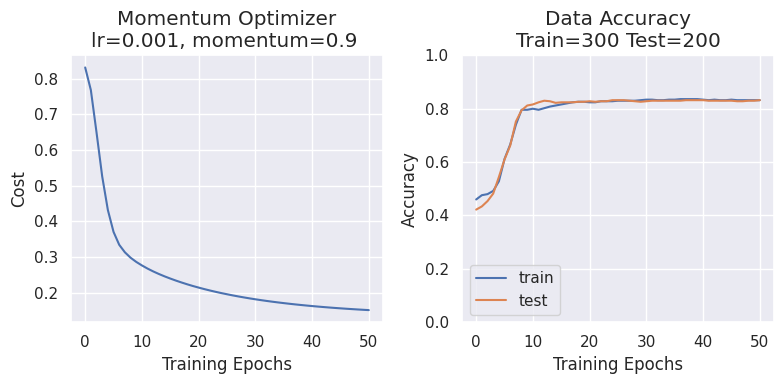

In [12]:
fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=100)
plot_x = list(range(51))

ax[0].plot(plot_x, result_hypersphere[1])
ax[0].set_title('Momentum Optimizer\nlr=0.001, momentum=0.9 ', fontsize='large')
ax[0].set_xlabel('Training Epochs')
ax[0].set_ylabel('Cost')

ax[1].set_ylim(0,1)
ax[1].plot(plot_x, result_hypersphere[2], label='train')
ax[1].plot(plot_x, result_hypersphere[3], label='test')
ax[1].set_title('Data Accuracy\nTrain=300 Test=200', fontsize='large')
ax[1].set_xlabel('Training Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()